In [1]:
from glob import glob
from pathlib import Path
from typing import List
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from fatescal.ces import daalgorithms as da
from fatescal.tools import unit_conversion as uc
from fatescal.tools import metrics
from fatescal.config import PROJECT_ROOT_PATH, \
    VARIABLES_TO_ASSIMILATE

In [2]:
# Define paths and file names
# --> test n Kalman iterations with synthetic truth run targets
case_names: List[str] = [
    "HYY_ST_n128_K1_1D_gpp_et",
    "HYY_ST_n128_K2_1D_gpp_et",
    "HYY_ST_n128_K4_1D_gpp_et",
]
# Store corresponding number of Kalman iterations in same order
kalman_iterations: List[int] = [1, 2, 4]

# ...used the same file stems
file_stems: List[str] = ['HYY_ST_vcmax85_bbslope80']*len(case_names)

result_dir_path: Path = PROJECT_ROOT_PATH / 'data' / 'results'
plot_save_path: Path = result_dir_path / 'plots' / \
    'publication_results' / 'enkf_n_iterations'

if not plot_save_path.is_dir():
    plot_save_path.mkdir(parents=True)

feature_matrix_paths: List[Path] = [
    result_dir_path / 'emulation' / 'feature_matrix' / case_name 
    for case_name in case_names
]

In [3]:
feature_matrices: List[pd.DataFrame] = [
    pd.read_csv(
        feature_matrix_path / f'{file_stem}.csv',
        index_col=0
    )
    for feature_matrix_path, file_stem in zip(feature_matrix_paths, file_stems)
]

In [4]:
# Transform parameters in feature matrices to model space
model_space_parameters: List[pd.DataFrame] = [
    da.transform_included_fates_parameters(
        parameter_matrix=param_df,
        how='to_model_space'
    )
    for param_df in feature_matrices
]

# Add column for Kalman iteration

for cur_kalman_iter, model_param_df in zip(
    kalman_iterations, model_space_parameters
):
    n_ensemble_members  = int(model_param_df.shape[0] / (cur_kalman_iter + 1))
    model_param_df["kalman_iter"] = [None] * model_param_df.shape[0]

    for idx in range(cur_kalman_iter+1):
        if idx==0:
            model_param_df["kalman_iter"].iloc[:n_ensemble_members] = \
                ['Prior'] * n_ensemble_members
        else:
            model_param_df["kalman_iter"].iloc[
                n_ensemble_members*idx:(n_ensemble_members*(idx+1))
            ] = [f'K. iteration {idx}'] * n_ensemble_members

/tmp/ipykernel_3019160/962767477.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_param_df["kalman_iter"].iloc[:n_ensemble_members] = \
/tmp/ipykernel_3019160/962767477.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_param_df["kalman_iter"].iloc[
/tmp/ipykernel_3019160/962767477.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_param_df["kalman_iter"].iloc[:n_ensemble_members] = \
/tmp/ipykernel_3019160/96

In [5]:
import json
with open(
    result_dir_path.parent / 'dict' / 'param_names.json', 'r',
    encoding="utf-8"
) as param_name_json:
    param_dict = json.load(param_name_json)

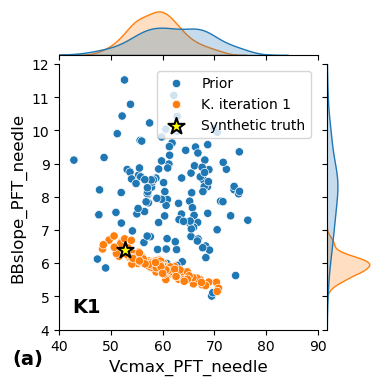

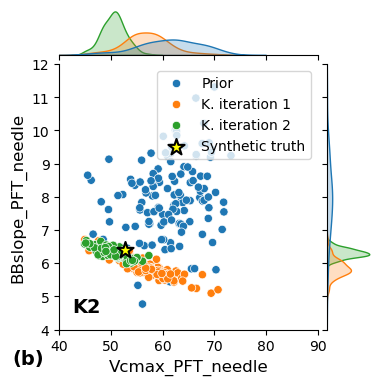

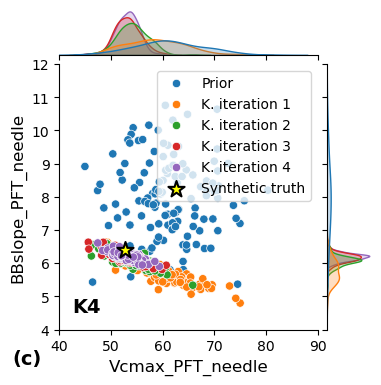

In [8]:
# PLOTS FOR NEEDLE-LEAF TREE VCMAX AND BBSLOPE
# https://stackoverflow.com/questions/35042255/how-to-plot-multiple-seaborn-jointplot-in-subplot
save_fig = True
plot_size_cm = 10

param_1 = "fates_leaf_vcmax25top_PFT2"
param_2 = "fates_leaf_stomatal_slope_ballberry_PFT2"

param_1_true_val = 52.7
param_2_true_val = 6.4

fig_labels = {
    "1": "(a)",
    "2": "(b)",
    "4": "(c)",
}

for cur_kalman_iter, model_param_df in zip(
    kalman_iterations, model_space_parameters
):

    joint_plot = sns.jointplot(
        data=model_param_df,
        x=param_1,
        y=param_2,
        hue="kalman_iter",
        height=plot_size_cm/2.54,
    )

    joint_plot.ax_joint.set_xlabel(
        param_dict[param_1]['pltname'],
        fontsize=12
    )
    joint_plot.ax_joint.set_ylabel(
        param_dict[param_2]['pltname'],
        fontsize=12
    )

    # Set x-y-limits
    joint_plot.ax_joint.set_xlim(
        left=40,
        right=90,
    )
    joint_plot.ax_joint.set_ylim(
        bottom=4,
        top=12,
    )

    #joint_plot.ax_joint.set_title(f"K{kalman_iterations}")

    # Plot synthetic truth target values!
    joint_plot.ax_joint.scatter(
        param_1_true_val,
        param_2_true_val,
        marker="*",
        s=150,
        color="yellow",
        edgecolors="black",
        linewidths=1.5,
        zorder=999,
        label="Synthetic truth"
    )

    handles, labels = joint_plot.ax_joint.get_legend_handles_labels()
    joint_plot.ax_joint.legend(
        handles=handles[0:],
        labels=labels[0:]
    )

    joint_plot.ax_joint.text(
        0.05, 0.05,
        f"K{cur_kalman_iter}",
        ha='left',
        va='bottom',
        transform=joint_plot.ax_joint.transAxes,
        fontsize=14,
        fontweight='bold',
    )

    joint_plot.fig.text(
        0.05, 0.05,
        fig_labels[str(cur_kalman_iter)],
        ha='left',
        va='bottom',
        #transform=joint_plot.ax_joint.transAxes,
        fontsize=14,
        fontweight='demibold',
    )

    #joint_plot.fig.tight_layout()

    # fig = joint_plot.get_figure()
    if save_fig:
        joint_plot.savefig(
            plot_save_path / 
            f"{param_dict[param_1]['pltname']}_AND_{param_dict[param_2]['pltname']}_K{cur_kalman_iter}.png",
            dpi=300
        )

In [ ]:
# PLOTS FOR ALL PARAMETER COMBINATIONS
save_fig = False

for row_idx, param_1 in enumerate(model_param_df.columns[:-1]):
    for col_idx, param_2 in enumerate(model_param_df.columns[:-1]):

        # No need for redundancy
        if row_idx >= col_idx:
            continue

        joint_plot = sns.jointplot(
            data=model_param_df,
            x=param_1,
            y=param_2,
            hue="kalman_iter",
            height=6/2.54,
        )

        joint_plot.ax_joint.set_xlabel(param_dict[param_1])
        joint_plot.ax_joint.set_ylabel(param_dict[param_2])

        # Plot synthetic truth target values!

        handles, labels = joint_plot.ax_joint.get_legend_handles_labels()
        joint_plot.ax_joint.legend(
            handles=handles[0:],
            labels=labels[0:]
        )

        # fig = joint_plot.get_figure()
        if save_fig:
            joint_plot.savefig(
                plot_save_path / 
                f'{param_dict[param_1]}_AND_{param_dict[param_2]}.png',
                dpi=300
            )

---
# Plot RMSE

In [10]:
# Retrieve variable names
obs_var_names = [
    x['Observed']['csv_col_name']for x in VARIABLES_TO_ASSIMILATE
]
model_var_names = [
    x['CLM-FATES']['history_var_name'] for x in VARIABLES_TO_ASSIMILATE
]

aligned_results_case_paths: List[Path] = [
    result_dir_path / 'aligned_obs_model' / case_name
    for case_name in case_names
]

final_iterations_dirs_paths : List[str] = [
    sorted(glob(str(path / 'kalman_iter_*')))[-1]  # Final iterations
    for path in aligned_results_case_paths
]
# Also prepend a prior run
final_iterations_dirs_paths.insert(
    0,
    str(aligned_results_case_paths[0] / 'kalman_iter_0')
)

In [11]:
final_iterations_dirs_paths

['/cluster/work/users/lassetk/fates-parameter-calibration/data/results/aligned_obs_model/HYY_ST_n128_K1_1D_gpp_et/kalman_iter_0',
 '/cluster/work/users/lassetk/fates-parameter-calibration/data/results/aligned_obs_model/HYY_ST_n128_K1_1D_gpp_et/kalman_iter_1',
 '/cluster/work/users/lassetk/fates-parameter-calibration/data/results/aligned_obs_model/HYY_ST_n128_K2_1D_gpp_et/kalman_iter_2',
 '/cluster/work/users/lassetk/fates-parameter-calibration/data/results/aligned_obs_model/HYY_ST_n128_K4_1D_gpp_et/kalman_iter_4']

In [12]:
kalman_model_dfs: List[pd.DataFrame] = []

for idx, kalman_dir in enumerate(final_iterations_dirs_paths):

    if idx==0:

        obs_csv_glob_list: list = glob(
            kalman_dir + '/O_*.csv'
        )

        obs_df = pd.read_csv(obs_csv_glob_list[0])
        obs_df['samptime'] = pd.to_datetime(obs_df['samptime'])
        for var in obs_var_names:
            obs_df[var] = uc.convert_unit(
                values=obs_df[var],
                unit_in='kg s-1',
                unit_out='g d-1'
            )

    kalman_csv_glob_list = sorted(glob(
        kalman_dir + '/M_*.csv'
    ))

    model_df_list = []

    for mpath in kalman_csv_glob_list:
        cur_df = pd.read_csv(mpath)
        cur_df['time'] = pd.to_datetime(cur_df['time'])
        for var in model_var_names:
            cur_df[var] = uc.convert_unit(
                values=cur_df[var],
                unit_in='kg s-1',
                unit_out='g d-1'
            )
        model_df_list.append(cur_df)

    kalman_model_dfs.append(model_df_list)

In [13]:
# Calculate RMSE for each ensemble member in each K iteration
kalman_rmse_list = []
kalman_r2_list = []
kalman_bias_list = []

for model_df_list in kalman_model_dfs:

    rmse_df = pd.DataFrame(columns=obs_var_names)
    r2_df = pd.DataFrame(columns=obs_var_names)
    bias_df = pd.DataFrame(columns=obs_var_names)
    
    for ens_idx, model_df in enumerate(model_df_list):

        for obs_var_name, model_var_name in zip(
            obs_var_names, model_var_names
        ):

            # Convert ET values to kg d-1
            if obs_var_name == "ET_gapf":
                rmse_df.loc[ens_idx, obs_var_name] = \
                    metrics.rmse(
                        actual=obs_df[obs_var_name] / 1000,
                        predicted=model_df[model_var_name] / 1000
                    )

                r2_df.loc[ens_idx, obs_var_name] = \
                    round(
                        metrics.linear_regression(
                            actual=obs_df[obs_var_name] / 1000,
                            predicted=model_df[model_var_name] / 1000
                        ).rvalue**2,
                        ndigits=3
                    )
                
                bias_df.loc[ens_idx, obs_var_name] = \
                    metrics.bias(
                        actual=obs_df[obs_var_name] / 1000,
                        predicted=model_df[model_var_name] / 1000
                    )
            else:
                rmse_df.loc[ens_idx, obs_var_name] = \
                    metrics.rmse(
                        actual=obs_df[obs_var_name],
                        predicted=model_df[model_var_name]
                    )
                r2_df.loc[ens_idx, obs_var_name] = \
                    round(
                        metrics.linear_regression(
                            actual=obs_df[obs_var_name],
                            predicted=model_df[model_var_name]
                        ).rvalue**2,
                        ndigits=3
                    )
                
                bias_df.loc[ens_idx, obs_var_name] = \
                    metrics.bias(
                        actual=obs_df[obs_var_name],
                        predicted=model_df[model_var_name]
                    )
    
    kalman_rmse_list.append(rmse_df)
    kalman_r2_list.append(r2_df)
    kalman_bias_list.append(bias_df)

In [14]:
# Calculate mean, max and min for each kalman iteration
kalman_rmse_stats_df_list = []
kalman_r2_stats_df_list = []
kalman_bias_stats_df_list = []


for rmse_df_list, r2_df_list, bias_df_list in zip(
    kalman_rmse_list, kalman_r2_list, kalman_bias_list
):

    rmse_stats_df = pd.DataFrame(
            columns=obs_var_names,
            index=["mean", "max", "min", "std"]
    )
    r2_stats_df = pd.DataFrame(
            columns=obs_var_names,
            index=["mean", "std"]
    )
    bias_stats_df = pd.DataFrame(
            columns=obs_var_names,
            index=["mean", "std"]
    )

    for obs_var_name in obs_var_names:

        rmse_stats_df.loc["mean", obs_var_name] = np.mean(rmse_df_list[obs_var_name])
        rmse_stats_df.loc["min", obs_var_name] = np.min(rmse_df_list[obs_var_name])
        rmse_stats_df.loc["max", obs_var_name] = np.max(rmse_df_list[obs_var_name])
        rmse_stats_df.loc["std", obs_var_name] = np.std(rmse_df_list[obs_var_name])

        r2_stats_df.loc["mean", obs_var_name] = np.mean(r2_df_list[obs_var_name])
        r2_stats_df.loc["std", obs_var_name] = np.std(r2_df_list[obs_var_name])

        bias_stats_df.loc["mean", obs_var_name] = np.mean(bias_df_list[obs_var_name])
        bias_stats_df.loc["std", obs_var_name] = np.std(bias_df_list[obs_var_name])
    
    kalman_rmse_stats_df_list.append(rmse_stats_df)
    kalman_r2_stats_df_list.append(r2_stats_df)
    kalman_bias_stats_df_list.append(bias_stats_df)

/tmp/ipykernel_3019160/2821696478.py:41: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  joint_plot.ax_joint.errorbar(


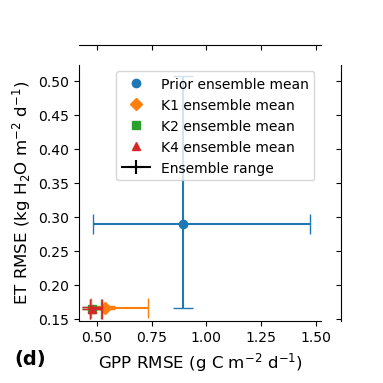

In [19]:
# Create plot
# Plot
save_fig = True
plot_size_cm = 10

joint_plot = sns.jointplot(
    data=pd.DataFrame(),
    x=pd.DataFrame(),
    y=pd.DataFrame(),
    height=plot_size_cm/2.54,
)


kalman_markers_dict = {
    "0": "o",
    "1": "D",
    "2": "s",
    "4": "^",
}

for k_idx, kalman_rmse_stats_df in zip([0]+kalman_iterations, kalman_rmse_stats_df_list):

    if k_idx==0:
        pass
        #continue

    xerr = np.array([
        [kalman_rmse_stats_df.loc['mean', 'GPP'] - kalman_rmse_stats_df.loc['min', 'GPP']],
        [kalman_rmse_stats_df.loc['max', 'GPP'] - kalman_rmse_stats_df.loc['mean', 'GPP']]
    ])
    yerr = np.array([
        [kalman_rmse_stats_df.loc['mean', 'ET_gapf'] - kalman_rmse_stats_df.loc['min', 'ET_gapf']],
        [kalman_rmse_stats_df.loc['max', 'ET_gapf'] - kalman_rmse_stats_df.loc['mean', 'ET_gapf']]
    ])

    if k_idx == 0:
        label = "Prior ensemble mean"
    else:
        label = f"K{k_idx} ensemble mean"
    
    joint_plot.ax_joint.errorbar(
        x=kalman_rmse_stats_df.loc['mean', 'GPP'],
        y=kalman_rmse_stats_df.loc['mean', 'ET_gapf'],
        xerr=xerr,
        yerr=yerr,
        fmt='o',
        ms=6,
        marker=kalman_markers_dict[str(k_idx)],
        label=label,
        zorder=k_idx,
        #alpha=0.7,
        capsize=7,
    )

joint_plot.ax_joint.set_xlabel(
    "GPP RMSE "+r"(g C m$^{-2}$ d$^{-1}$)",
    fontsize=12
)
joint_plot.ax_joint.set_ylabel(
    "ET RMSE "+r"(kg H$_{2}$O m$^{-2}$ d$^{-1}$)",
    fontsize=12
)

# Dummy errorbar
joint_plot.ax_joint.errorbar(
    x=[],
    y=[],
    xerr=[1],
    yerr=[1],
    fmt='-',
    color="black",
    label="Ensemble range",
    capsize=6,
)

handles, labels = joint_plot.ax_joint.get_legend_handles_labels()
# remove the errorbars
from matplotlib import container
handles[:-1] = [h[0] if isinstance(h, container.ErrorbarContainer) else h for h in handles[:-1]]

joint_plot.ax_joint.legend(handles=handles, labels=labels)

joint_plot.fig.text(
    0.05, 0.05,
    "(d)",
    ha='left',
    va='bottom',
    #transform=joint_plot.ax_joint.transAxes,
    fontsize=14,
    fontweight='demibold',
)

joint_plot.fig.tight_layout()

if save_fig:
    joint_plot.savefig(
        plot_save_path / 
        f"iterations_RMSE_comparison.png",
        dpi=300
    )

---
# Create table of paramter means etc.

In [7]:
param_stats_table = pd.DataFrame(
    columns=["Def", "ST", "K1_mean", "K1_std", "K2_mean", "K2_std", "K4_mean", "K4_std"],
    index=[param_dict[x]['pltname'] for x in param_dict.keys()],
)

param_stats_table["Def"] = [62.0, 58.0, 78.0, 8.0, 8.0, 8.0]
param_stats_table["ST"] = [52.7, 49.3, 66.3, 6.4, 6.4, 6.4]

for cur_kalman_iter, model_param_df in zip(
    kalman_iterations, model_space_parameters
):
    #n_ensemble_members  = int(model_param_df.shape[0] / (cur_kalman_iter + 1))
    mask = (model_param_df["kalman_iter"] == f"K. iteration {cur_kalman_iter}")

    # Ensemble means
    param_stats_table[f"K{cur_kalman_iter}_mean"] = \
        np.round(np.mean(model_param_df.loc[mask], axis=0), 2).values
    
    # Ensemble standard dev.s
    param_stats_table[f"K{cur_kalman_iter}_std"] = \
        np.round(np.std(model_param_df.loc[mask], axis=0), 2).values

/cluster/work/users/lassetk/conda_envs/fatescal-env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3462: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/cluster/work/users/lassetk/conda_envs/fatescal-env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3603: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/cluster/work/users/lassetk/conda_envs/fatescal-env/lib/python3.11/site-packages/numpy/core/fromnum

In [8]:
param_stats_table

,Def,ST,K1_mean,K1_std,K2_mean,K2_std,K4_mean,K4_std
Vcmax_PFT_needle,62.0,52.7,58.94,4.76,50.53,2.28,53.19,2.09
Vcmax_PFT_broad,58.0,49.3,58.96,5.59,61.01,6.00,55.54,5.70
Vcmax_PFT_grass,78.0,66.3,73.93,8.27,76.48,9.32,67.68,7.26
BBslope_PFT_needle,8.0,6.4,5.94,0.32,6.31,0.14,6.20,0.12
BBslope_PFT_broad,8.0,6.4,6.89,0.80,8.08,0.79,7.72,0.73
BBslope_PFT_grass,8.0,6.4,7.49,1.10,5.95,0.89,6.43,0.77


In [102]:
print(param_stats_table.to_latex())

\begin{tabular}{lrrrlrlrl}
\toprule
{} &    ST &   Def &  K1\_mean & K1\_std &  K2\_mean & K2\_std &  K4\_mean & K4\_std \\
\midrule
Vcmax\_PFT\_needle   &  52.7 &  62.0 &    58.94 &    NaN &    50.53 &    NaN &    53.19 &    NaN \\
Vcmax\_PFT\_broad    &  49.3 &  58.0 &    58.96 &    NaN &    61.01 &    NaN &    55.54 &    NaN \\
Vcmax\_PFT\_grass    &  66.3 &  78.0 &    73.93 &    NaN &    76.48 &    NaN &    67.68 &    NaN \\
BBslope\_PFT\_needle &   6.4 &   8.0 &     5.94 &    NaN &     6.31 &    NaN &     6.20 &    NaN \\
BBslope\_PFT\_broad  &   6.4 &   8.0 &     6.89 &    NaN &     8.08 &    NaN &     7.72 &    NaN \\
BBslope\_PFT\_grass  &   6.4 &   8.0 &     7.49 &    NaN &     5.95 &    NaN &     6.43 &    NaN \\
\bottomrule
\end{tabular}



/tmp/ipykernel_42918/1830370845.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(param_stats_table.to_latex())


In [54]:
kalman_rmse_stats_df_list[3]

,GPP,ET_gapf
mean,0.476949,0.165115
max,0.521275,0.167271
min,0.469261,0.164401
std,0.008746,0.000542


In [58]:
rmse_df.loc["mean", "GPP"]

0.8933465446494089

In [65]:
results_stats_table = pd.DataFrame(
    columns=["Def", "ST", "K1_mean", "K1_std", "K2_mean", "K2_std", "K4_mean", "K4_std"],
    index=["GPP_RMSE", "GPP_r2", "GPP_bias", "ET_RMSE", "ET_r2", "ET_bias"],
)

results_stats_table["ST"] = ["-"] * results_stats_table.shape[0]

for cur_kalman_iter, rmse_df, r2_df, bias_df in zip(
    [0] + kalman_iterations,
    kalman_rmse_stats_df_list,
    kalman_r2_stats_df_list,
    kalman_bias_stats_df_list
):

    # GPP
    results_stats_table.loc["GPP_RMSE", f"K{cur_kalman_iter}_mean"] = \
        np.round(rmse_df.loc["mean", "GPP"], 2)
    results_stats_table.loc["GPP_RMSE", f"K{cur_kalman_iter}_std"] = \
        np.round(rmse_df.loc["std", "GPP"], 2)

    results_stats_table.loc["GPP_r2", f"K{cur_kalman_iter}_mean"] = \
        np.round(r2_df.loc["mean", "GPP"], 2)
    results_stats_table.loc["GPP_r2", f"K{cur_kalman_iter}_std"] = \
        np.round(r2_df.loc["std", "GPP"], 2)

    results_stats_table.loc["GPP_bias", f"K{cur_kalman_iter}_mean"] = \
        np.round(bias_df.loc["mean", "GPP"], 2)
    results_stats_table.loc["GPP_bias", f"K{cur_kalman_iter}_std"] = \
        np.round(bias_df.loc["std", "GPP"], 2)

    # ET
    results_stats_table.loc["ET_RMSE", f"K{cur_kalman_iter}_mean"] = \
        np.round(rmse_df.loc["mean", "ET_gapf"], 2)
    results_stats_table.loc["ET_RMSE", f"K{cur_kalman_iter}_std"] = \
        np.round(rmse_df.loc["std", "ET_gapf"], 2)

    results_stats_table.loc["ET_r2", f"K{cur_kalman_iter}_mean"] = \
        np.round(r2_df.loc["mean", "ET_gapf"], 2)
    results_stats_table.loc["ET_r2", f"K{cur_kalman_iter}_std"] = \
        np.round(r2_df.loc["std", "ET_gapf"], 2)

    results_stats_table.loc["ET_bias", f"K{cur_kalman_iter}_mean"] = \
        np.round(bias_df.loc["mean", "ET_gapf"], 2)
    results_stats_table.loc["ET_bias", f"K{cur_kalman_iter}_std"] = \
        np.round(bias_df.loc["std", "ET_gapf"], 2)
results_stats_table

,Def,ST,K1_mean,K1_std,K2_mean,K2_std,K4_mean,K4_std,K0_mean,K0_std
GPP_RMSE,NaN,-,0.54,0.06,0.48,0.01,0.48,0.01,0.89,0.24
GPP_r2,NaN,-,0.98,0.0,0.98,0.0,0.98,0.0,0.98,0.00
GPP_bias,NaN,-,-0.17,0.09,0.02,0.06,-0.02,0.05,-0.48,0.22
ET_RMSE,NaN,-,0.17,0.0,0.17,0.0,0.17,0.0,0.29,0.09
ET_r2,NaN,-,0.98,0.0,0.98,0.0,0.98,0.0,0.97,0.01
ET_bias,NaN,-,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.12,0.06
